In [48]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
import gc
import warnings

In [49]:
warnings.filterwarnings('ignore')

In [50]:
# Load all the necessary CSV files into pandas DataFrames.
try:
    # Training data
    orders = pd.read_csv('Train/orders.csv')
    train_customers = pd.read_csv('Train/train_customers.csv')
    train_locations = pd.read_csv('Train/train_locations.csv')
    vendors = pd.read_csv('Train/vendors.csv')

    # Testing data
    test_customers = pd.read_csv('Test/test_customers.csv')
    test_locations = pd.read_csv('Test/test_locations.csv')
    
    # Sample submission for structure
    sample_submission = pd.read_csv('SampleSubmission.csv')
    print("Data loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading files: {e}")
    print("Please ensure your data files are in the 'Train' and 'Test' subdirectories.")
    exit()

Data loaded successfully.


Memory Optimization & Initial Cleaning

In [51]:

orders.rename(columns={'LOCATION_NUMBER': 'location_number'}, inplace=True) 
orders = orders.drop(columns=['vendor_rating', 'LOCATION_TYPE'], errors='ignore')

# Convert columns to memory-efficient types
orders['item_count'] = pd.to_numeric(orders['item_count'], errors='coerce').astype('float16')
orders['grand_total'] = pd.to_numeric(orders['grand_total'], errors='coerce').astype('float32')
train_locations['location_number'] = pd.to_numeric(train_locations['location_number'], errors='coerce').astype('int8')
test_locations['location_number'] = pd.to_numeric(test_locations['location_number'], errors='coerce').astype('int8')
orders['location_number'] = pd.to_numeric(orders['location_number'], errors='coerce').astype('int8')

vendors['vendor_id'] = vendors['id']
vendors['vendor_rating'] = pd.to_numeric(vendors['vendor_rating'], errors='coerce').astype('float16')
print("Memory optimized and columns cleaned.")

Memory optimized and columns cleaned.


In [52]:
# Time-based features
orders['created_at'] = pd.to_datetime(orders['created_at'])
orders['order_hour'] = orders['created_at'].dt.hour
orders['order_dayofweek'] = orders['created_at'].dt.dayofweek

In [53]:
customer_time_prefs = orders.groupby('customer_id').agg(
    cust_avg_hour=('order_hour', 'mean'),
    cust_avg_day=('order_dayofweek', 'mean')
)
vendor_time_prefs = orders.groupby('vendor_id').agg(
    vendor_avg_hour=('order_hour', 'mean'),
    vendor_avg_day=('order_dayofweek', 'mean')
)

In [54]:
# Customer behavior features
orders = orders.sort_values(['customer_id', 'created_at'])
orders['time_since_last_order'] = orders.groupby('customer_id')['created_at'].diff().dt.total_seconds() / 3600 # in hours
customer_time_agg = orders.groupby('customer_id')['time_since_last_order'].agg(['mean', 'std']).rename(columns={'mean': 'cust_mean_time_between_orders', 'std': 'cust_std_time_between_orders'})
customer_time_agg 

,cust_mean_time_between_orders,cust_std_time_between_orders
customer_id,,
000THBA,NaN,NaN
002510Y,NaN,NaN
005ECL6,43177.300000,NaN
0075AM7,NaN,NaN
009UFS1,1480.177778,1113.879332
...,...,...
ZZVGIVK,3335.983333,NaN
ZZVLIB5,3874.909091,11389.800286
ZZWKMGG,NaN,NaN


In [55]:
# Popularity features
vendor_popularity = orders['vendor_id'].value_counts().to_frame('vendor_popularity_rank')
customer_spending_rank = orders.groupby('customer_id')['grand_total'].sum().rank(ascending=False).to_frame('customer_spending_rank')
customer_spending_rank

,customer_spending_rank
customer_id,
000THBA,14188.0
002510Y,20770.5
005ECL6,10296.5
0075AM7,15332.5
009UFS1,14215.0
...,...
ZZVGIVK,12140.0
ZZVLIB5,486.0
ZZWKMGG,16596.5


In [56]:
# --- Vendor Features ---
vendors['vendor_tag_count'] = vendors['vendor_tag_name'].str.count(',') + 1
vendors_cleaned = vendors[['vendor_id', 'latitude', 'longitude', 'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count']].rename(columns={'latitude': 'vendor_latitude', 'longitude': 'vendor_longitude'})
vendors_cleaned = vendors_cleaned.merge(vendor_popularity, left_on='vendor_id', right_index=True, how='left')
vendors_cleaned = vendors_cleaned.merge(vendor_time_prefs, left_on='vendor_id', right_index=True, how='left')
vendors_cleaned

,vendor_id,vendor_latitude,vendor_longitude,vendor_rating,serving_distance,prepration_time,vendor_tag_count,vendor_popularity_rank,vendor_avg_hour,vendor_avg_day
0,4,-0.588596,0.754434,4.398438,6,15,10.0,2137,14.508657,2.573701
1,13,-0.471654,0.744470,4.699219,5,14,9.0,731,14.585499,2.682627
2,20,-0.407527,0.643681,4.500000,8,19,4.0,1587,13.284184,2.737870
3,23,-0.585385,0.753811,4.500000,5,16,4.0,920,14.560870,2.878261
4,28,0.480602,0.552850,4.398438,15,10,1.0,1537,14.253090,2.905660
...,...,...,...,...,...,...,...,...,...,...
95,849,-1.588060,-0.066441,4.101562,10,10,10.0,1067,15.188379,2.991565
96,855,2.145206,0.745025,4.199219,8,10,7.0,831,14.417569,2.978339
97,856,0.251469,0.483633,4.300781,7,10,10.0,1054,15.462998,2.997154
98,858,0.019817,0.587087,4.199219,3,10,10.0,860,15.686047,2.910465


In [57]:
# --- Customer Features ---
all_customers = pd.concat([train_customers, test_customers], ignore_index=True)
all_customers['dob'] = pd.to_numeric(all_customers['dob'], errors='coerce')
all_customers['age'] = 2025 - all_customers['dob']
all_customers['age'].fillna(all_customers['age'].median(), inplace=True)
all_customers['created_at'] = pd.to_datetime(all_customers['created_at'], errors='coerce')
all_customers['account_age_days'] = (pd.to_datetime('2025-08-01') - all_customers['created_at']).dt.days
all_customers['gender'].fillna('Unknown', inplace=True)
le_gender = LabelEncoder()
all_customers['gender_encoded'] = le_gender.fit_transform(all_customers['gender'])
customers_cleaned = all_customers[['customer_id', 'age', 'account_age_days', 'gender_encoded']]
customers_cleaned = customers_cleaned.merge(customer_spending_rank, left_on='customer_id', right_index=True, how='left')
customers_cleaned = customers_cleaned.merge(customer_time_agg, left_on='customer_id', right_index=True, how='left')
customers_cleaned = customers_cleaned.merge(customer_time_prefs, left_on='customer_id', right_index=True, how='left')
customers_cleaned

,customer_id,age,account_age_days,gender_encoded,customer_spending_rank,cust_mean_time_between_orders,cust_std_time_between_orders,cust_avg_hour,cust_avg_day
0,TCHWPBT,32.0,905.0,7,20919.0,943.816667,NaN,9.000000,1.000000
1,ZGFSYCZ,32.0,903.0,7,237.0,1091.637083,5919.064206,14.390244,3.536585
2,S2ALZFL,32.0,870.0,7,7927.0,748.266667,356.567013,17.500000,3.000000
3,952DBJQ,32.0,869.0,7,15749.0,1176.250000,832.004773,19.500000,2.250000
4,1IX6FXS,32.0,869.0,7,769.5,2147.630833,8334.239077,9.047619,2.714286
...,...,...,...,...,...,...,...,...,...
44437,369I4YD,32.0,150.0,9,NaN,NaN,NaN,NaN,NaN
44438,VUOXW5K,32.0,150.0,9,NaN,NaN,NaN,NaN,NaN
44439,H1S2T2Y,32.0,150.0,9,NaN,NaN,NaN,NaN,NaN
44440,QGPCD5S,32.0,150.0,9,NaN,NaN,NaN,NaN,NaN


In [58]:
# --- Location Features ---
all_locations = pd.concat([train_locations, test_locations], ignore_index=True)

In [59]:
# --- Merge Orders with Features ---
train_df = orders.merge(customers_cleaned, on='customer_id', how='left')
train_df = train_df.merge(all_locations, on=['customer_id', 'location_number'], how='left')
train_df = train_df.merge(vendors_cleaned, on='vendor_id', how='left')
train_df['target'] = 1
train_df

,order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,vendor_latitude,vendor_longitude,vendor_rating,serving_distance,prepration_time,vendor_tag_count,vendor_popularity_rank,vendor_avg_hour,vendor_avg_day,target
0,222348.0,000THBA,NaN,29.600000,2,NaN,0.0,NaN,No,No,...,-0.482865,0.075989,4.101562,15,16,6.0,1078,15.807978,2.825603,1
1,126088.0,002510Y,3.0,13.600000,2,NaN,0.0,NaN,NaN,No,...,0.055885,0.533995,4.300781,15,15,6.0,1746,15.491982,2.840206,1
2,336261.0,005ECL6,4.0,25.299999,1,NaN,0.0,0.0,No,No,...,-0.943419,0.081702,4.601562,15,15,8.0,889,17.402700,2.998875,1
3,304576.0,005ECL6,5.0,23.400000,1,NaN,0.0,0.0,No,No,...,-0.943419,0.081702,4.601562,15,15,8.0,889,17.402700,2.998875,1
4,402450.0,0075AM7,1.0,25.799999,1,NaN,0.0,0.0,No,No,...,-0.605892,0.072953,3.199219,15,10,3.0,1046,14.673040,2.777247,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135497,265699.0,ZZY3N0D,1.0,8.200000,1,NaN,0.0,NaN,No,Yes,...,-0.498135,0.058017,4.500000,15,13,9.0,2837,17.677124,2.904829,1
135498,285179.0,ZZY3N0D,2.0,4.100000,1,NaN,0.0,0.0,No,Yes,...,-0.815323,0.091491,4.199219,15,10,7.0,1245,14.711647,2.936546,1
135499,292159.0,ZZY3N0D,2.0,7.600000,1,NaN,0.0,0.0,No,Yes,...,-0.996063,-0.062283,4.199219,10,15,4.0,1305,19.085824,2.665134,1
135500,318689.0,ZZY3N0D,1.0,7.900000,1,NaN,0.0,0.0,No,No,...,-0.845096,0.067013,4.199219,15,15,5.0,1647,18.681239,2.981785,1


In [60]:
# ---Negative Sampling ---
all_vendor_ids = vendors['vendor_id'].unique()
customer_vendor_pairs = train_df[['customer_id', 'vendor_id']].drop_duplicates()
all_combinations = pd.DataFrame(np.array(np.meshgrid(train_df['customer_id'].unique(), all_vendor_ids)).T.reshape(-1, 2), columns=['customer_id', 'vendor_id'])
negative_samples = all_combinations.merge(customer_vendor_pairs, on=['customer_id', 'vendor_id'], how='left', indicator=True)
negative_samples = negative_samples[negative_samples['_merge'] == 'left_only']
num_positive_samples = len(train_df)
negative_samples = negative_samples.sample(n=num_positive_samples * 2, random_state=42) 
negative_samples['target'] = 0
train_full = pd.concat([train_df, negative_samples], ignore_index=True)
train_full

,order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,vendor_longitude,vendor_rating,serving_distance,prepration_time,vendor_tag_count,vendor_popularity_rank,vendor_avg_hour,vendor_avg_day,target,_merge
0,222348.0,000THBA,NaN,29.600000,2.0,NaN,0.0,NaN,No,No,...,0.075989,4.101562,15.0,16.0,6.0,1078.0,15.807978,2.825603,1,NaN
1,126088.0,002510Y,3.0,13.600000,2.0,NaN,0.0,NaN,NaN,No,...,0.533995,4.300781,15.0,15.0,6.0,1746.0,15.491982,2.840206,1,NaN
2,336261.0,005ECL6,4.0,25.299999,1.0,NaN,0.0,0.0,No,No,...,0.081702,4.601562,15.0,15.0,8.0,889.0,17.402700,2.998875,1,NaN
3,304576.0,005ECL6,5.0,23.400000,1.0,NaN,0.0,0.0,No,No,...,0.081702,4.601562,15.0,15.0,8.0,889.0,17.402700,2.998875,1,NaN
4,402450.0,0075AM7,1.0,25.799999,1.0,NaN,0.0,0.0,No,No,...,0.072953,3.199219,15.0,10.0,3.0,1046.0,14.673040,2.777247,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406501,NaN,TSENVS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,left_only
406502,NaN,1OLWQIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,left_only
406503,NaN,TOCHQYF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,left_only
406504,NaN,860V4UT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,left_only


In [61]:
# Fill in missing features for the negative samples
cols_to_drop = [col for col in customers_cleaned.columns if col != 'customer_id'] + \
               [col for col in vendors_cleaned.columns if col != 'vendor_id'] + \
               ['latitude', 'longitude', 'location_type']
train_full = train_full.drop(columns=[col for col in cols_to_drop if col in train_full.columns])
train_full = train_full.merge(customers_cleaned, on='customer_id', how='left')
primary_locations = all_locations[all_locations['location_number'] == 0]
train_full = train_full.merge(primary_locations.drop(columns='location_number'), on='customer_id', how='left')
train_full = train_full.merge(vendors_cleaned, on='vendor_id', how='left')

In [62]:
# --- Final Feature Engineering on the Combined Dataset ---
train_full['distance_km'] = np.sqrt((train_full['latitude'] - train_full['vendor_latitude'])**2 + (train_full['longitude'] - train_full['vendor_longitude'])**2)
customer_agg = train_df.groupby('customer_id')['grand_total'].agg(['mean', 'count']).rename(columns={'mean': 'cust_avg_order_val', 'count': 'cust_order_count'})
vendor_agg = train_df.groupby('vendor_id')['grand_total'].agg(['mean', 'count']).rename(columns={'mean': 'vendor_avg_order_val', 'count': 'vendor_order_count'})
train_full = train_full.merge(customer_agg, on='customer_id', how='left')
train_full = train_full.merge(vendor_agg, on='vendor_id', how='left')
train_full

,order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,prepration_time,vendor_tag_count,vendor_popularity_rank,vendor_avg_hour,vendor_avg_day,distance_km,cust_avg_order_val,cust_order_count,vendor_avg_order_val,vendor_order_count
0,222348.0,000THBA,NaN,29.600000,2.0,NaN,0.0,NaN,No,No,...,16,6.0,1078,15.807978,2.825603,0.471488,29.600000,1,13.155380,1078
1,126088.0,002510Y,3.0,13.600000,2.0,NaN,0.0,NaN,NaN,No,...,15,6.0,1746,15.491982,2.840206,79.131620,13.600000,1,12.095475,1746
2,336261.0,005ECL6,4.0,25.299999,1.0,NaN,0.0,0.0,No,No,...,15,8.0,889,17.402700,2.998875,0.632329,24.349998,2,17.048368,889
3,304576.0,005ECL6,5.0,23.400000,1.0,NaN,0.0,0.0,No,No,...,15,8.0,889,17.402700,2.998875,0.632329,24.349998,2,17.048368,889
4,402450.0,0075AM7,1.0,25.799999,1.0,NaN,0.0,0.0,No,No,...,10,3.0,1046,14.673040,2.777247,0.691940,25.799999,1,9.717619,1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408722,NaN,TSENVS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,4.0,7807,15.842705,2.800820,1.285915,9.300000,2,14.646749,7814
408723,NaN,1OLWQIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,5.0,592,11.934122,2.927365,79.132150,15.923077,13,19.792568,592
408724,NaN,TOCHQYF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,7.0,1255,19.458167,2.826295,78.674601,6.550000,2,14.339521,1255
408725,NaN,860V4UT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,2.0,2054,12.708374,2.960078,79.339532,9.778571,14,10.910906,2054


In [63]:
# Fill NaNs for all generated features
for col in ['cust_avg_order_val', 'cust_order_count', 'vendor_avg_order_val', 'vendor_order_count', 
            'vendor_popularity_rank', 'customer_spending_rank', 'cust_mean_time_between_orders', 
            'cust_std_time_between_orders', 'cust_avg_hour', 'cust_avg_day', 'vendor_avg_hour', 'vendor_avg_day']:
    train_full[col].fillna(0, inplace=True)

train_full

,order_id,customer_id,item_count,grand_total,payment_mode,promo_code,vendor_discount_amount,promo_code_discount_percentage,is_favorite,is_rated,...,prepration_time,vendor_tag_count,vendor_popularity_rank,vendor_avg_hour,vendor_avg_day,distance_km,cust_avg_order_val,cust_order_count,vendor_avg_order_val,vendor_order_count
0,222348.0,000THBA,NaN,29.600000,2.0,NaN,0.0,NaN,No,No,...,16,6.0,1078,15.807978,2.825603,0.471488,29.600000,1,13.155380,1078
1,126088.0,002510Y,3.0,13.600000,2.0,NaN,0.0,NaN,NaN,No,...,15,6.0,1746,15.491982,2.840206,79.131620,13.600000,1,12.095475,1746
2,336261.0,005ECL6,4.0,25.299999,1.0,NaN,0.0,0.0,No,No,...,15,8.0,889,17.402700,2.998875,0.632329,24.349998,2,17.048368,889
3,304576.0,005ECL6,5.0,23.400000,1.0,NaN,0.0,0.0,No,No,...,15,8.0,889,17.402700,2.998875,0.632329,24.349998,2,17.048368,889
4,402450.0,0075AM7,1.0,25.799999,1.0,NaN,0.0,0.0,No,No,...,10,3.0,1046,14.673040,2.777247,0.691940,25.799999,1,9.717619,1050
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408722,NaN,TSENVS2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10,4.0,7807,15.842705,2.800820,1.285915,9.300000,2,14.646749,7814
408723,NaN,1OLWQIC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,5.0,592,11.934122,2.927365,79.132150,15.923077,13,19.792568,592
408724,NaN,TOCHQYF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20,7.0,1255,19.458167,2.826295,78.674601,6.550000,2,14.339521,1255
408725,NaN,860V4UT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15,2.0,2054,12.708374,2.960078,79.339532,9.778571,14,10.910906,2054


In [64]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408727 entries, 0 to 408726
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   order_id                        136530 non-null  float64       
 1   customer_id                     408727 non-null  object        
 2   item_count                      129675 non-null  float16       
 3   grand_total                     136600 non-null  float32       
 4   payment_mode                    136600 non-null  float64       
 5   promo_code                      4401 non-null    object        
 6   vendor_discount_amount          136600 non-null  float64       
 7   promo_code_discount_percentage  66992 non-null   float64       
 8   is_favorite                     101405 non-null  object        
 9   is_rated                        136600 non-null  object        
 10  driver_rating                   136600 non-null  float64

In [65]:
train_full.columns

Index(['order_id', 'customer_id', 'item_count', 'grand_total', 'payment_mode',
       'promo_code', 'vendor_discount_amount',
       'promo_code_discount_percentage', 'is_favorite', 'is_rated',
       'driver_rating', 'deliverydistance', 'preparationtime', 'delivery_time',
       'order_accepted_time', 'driver_accepted_time', 'ready_for_pickup_time',
       'picked_up_time', 'delivered_time', 'delivery_date', 'vendor_id',
       'created_at', 'location_number', 'CID X LOC_NUM X VENDOR', 'order_hour',
       'order_dayofweek', 'time_since_last_order', 'target', '_merge', 'age',
       'account_age_days', 'gender_encoded', 'customer_spending_rank',
       'cust_mean_time_between_orders', 'cust_std_time_between_orders',
       'cust_avg_hour', 'cust_avg_day', 'location_type', 'latitude',
       'longitude', 'vendor_latitude', 'vendor_longitude', 'vendor_rating',
       'serving_distance', 'prepration_time', 'vendor_tag_count',
       'vendor_popularity_rank', 'vendor_avg_hour', 'vendor_av

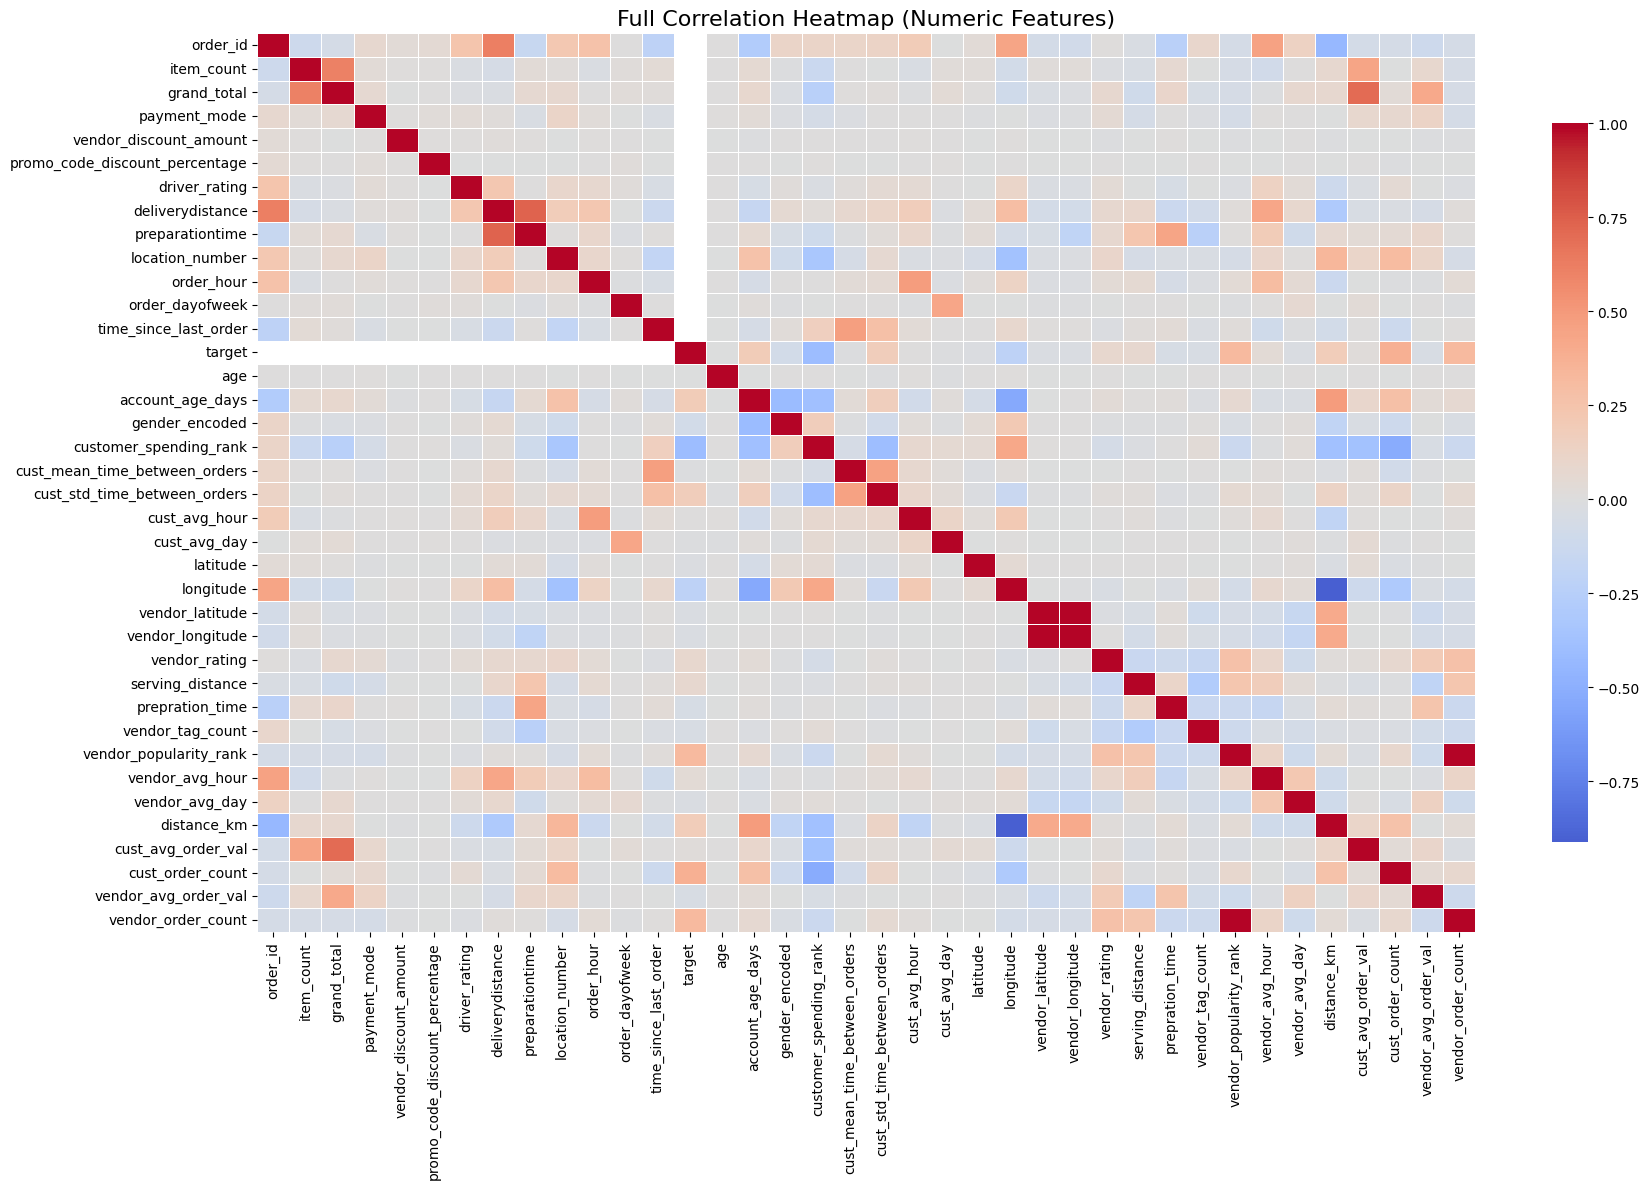

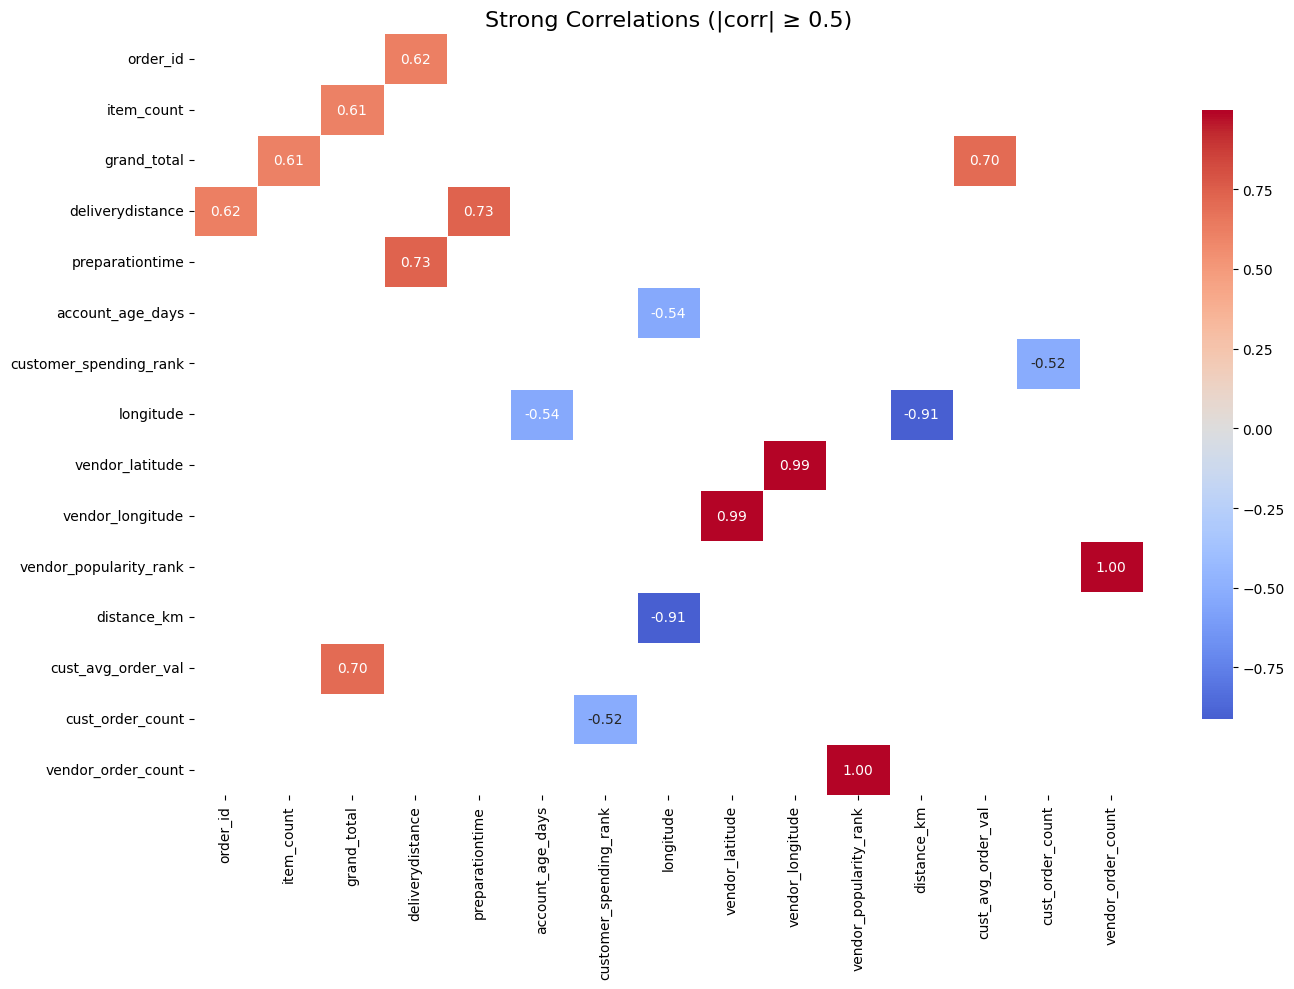

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Select only numeric columns
numeric_cols = train_full.select_dtypes(include=['number'])

# 2. Compute the full correlation matrix
corr_matrix = numeric_cols.corr()

# 3. Plot the full heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(corr_matrix, 
            annot=False, 
            cmap='coolwarm', 
            center=0, 
            fmt=".2f", 
            linewidths=0.5, 
            cbar_kws={"shrink": .8})
plt.title("Full Correlation Heatmap (Numeric Features)", fontsize=16)
plt.tight_layout()
plt.show()

# 4. Filter for strong correlations (|corr| >= 0.5 but not 1)
strong_corrs = corr_matrix.copy()
strong_corrs = strong_corrs[(abs(strong_corrs) >= 0.5) & (abs(strong_corrs) < 1.0)]

# Drop all-zero rows/columns (where no strong correlations exist)
strong_corrs = strong_corrs.dropna(how='all').dropna(axis=1, how='all')

# 5. Plot strong correlations heatmap if any
if not strong_corrs.empty:
    plt.figure(figsize=(14, 10))
    sns.heatmap(strong_corrs, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                fmt=".2f", 
                linewidths=0.5, 
                cbar_kws={"shrink": .8})
    plt.title("Strong Correlations (|corr| ≥ 0.5)", fontsize=16)
    plt.tight_layout()
    plt.show()
else:
    print("No strong correlations (|corr| ≥ 0.5) found among numeric features.")


In [67]:
train_full.isna().sum().sort_values(ascending=False)

promo_code                        404326
delivery_time                     403569
delivery_date                     373183
driver_accepted_time              361564
promo_code_discount_percentage    341735
preparationtime                   327687
picked_up_time                    323619
ready_for_pickup_time             323246
delivered_time                    321700
order_accepted_time               320475
is_favorite                       307322
time_since_last_order             300262
item_count                        279052
order_id                          272197
driver_rating                     272127
payment_mode                      272127
vendor_discount_amount            272127
is_rated                          272127
created_at                        272127
deliverydistance                  272127
location_number                   272127
grand_total                       272127
order_dayofweek                   272127
CID X LOC_NUM X VENDOR            272127
order_hour      

[
    'order_id',
    'customer_id',
    'item_count',
    'grand_total',
    'payment_mode',
    'promo_code',
    'vendor_discount_amount',
    'promo_code_discount_percentage',
    'is_favorite',
    'is_rated',
    'driver_rating',
    'deliverydistance',
    'preparationtime',
    'delivery_time',
    'order_accepted_time',
    'driver_accepted_time',
    'ready_for_pickup_time',
    'picked_up_time',
    'delivered_time',
    'delivery_date',
    'vendor_id',
    'created_at',
    'location_number',
    'CID X LOC_NUM X VENDOR',
    'order_hour',
    'order_dayofweek',
    'time_since_last_order',
    'cust_std_time_between_orders',
    'location_type',
    'latitude',
    'longitude',
    'vendor_latitude',
    'vendor_longitude',
    'target',
    '_merge'
]


In [68]:
features = [
    'age', 'account_age_days', 'gender_encoded', 'customer_spending_rank',
    'cust_avg_order_val', 'cust_order_count', 'cust_mean_time_between_orders',
    'cust_avg_hour', 'cust_avg_day',
    'vendor_rating', 'serving_distance', 'prepration_time', 'vendor_tag_count',
    'vendor_avg_order_val', 'vendor_order_count', 'vendor_popularity_rank',
    'vendor_avg_hour', 'vendor_avg_day',
    'distance_km'
]
target = 'target'
X = train_full[features].astype('float32')
y = train_full[target].astype('int8')

In [69]:
lgb_params_tuned = {
    'objective': 'binary', 'metric': 'auc', 'boosting_type': 'gbdt',
    'n_estimators': 2000, 'learning_rate': 0.02, # Slower learning rate
    'num_leaves': 40, 'max_depth': -1, 'seed': 42, 'n_jobs': -1, 'verbose': -1,
    'colsample_bytree': 0.7, 'subsample': 0.7, 'reg_alpha': 0.1, 'reg_lambda': 0.1,
}

In [70]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
    print(f"===== Fold {fold+1} =====")
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]
    
    model = lgb.LGBMClassifier(**lgb_params_tuned)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(150, verbose=False)])
    
    oof_preds[val_idx] = model.predict_proba(X_val)[:, 1]
    models.append(model) # Store the trained model
    
    # Prepare test set for prediction (done once and predicted in each fold)
    if fold == 0:
        test_df_base = pd.DataFrame(np.array(np.meshgrid(test_customers['customer_id'].unique(), all_vendor_ids)).T.reshape(-1, 2), columns=['customer_id', 'vendor_id'])
        test_df = test_customers.merge(test_locations, on='customer_id').merge(test_df_base, on='customer_id', how='left')
        test_df = test_df.merge(customers_cleaned, on='customer_id', how='left')
        test_df = test_df.merge(vendors_cleaned, on='vendor_id', how='left')
        test_df['distance_km'] = np.sqrt((test_df['latitude'] - test_df['vendor_latitude'])**2 + (test_df['longitude'] - test_df['vendor_longitude'])**2)
        test_df = test_df.merge(customer_agg, on='customer_id', how='left')
        test_df = test_df.merge(vendor_agg, on='vendor_id', how='left')
        
        # Fill NaNs for all generated features in the test set
        for col in ['cust_avg_order_val', 'cust_order_count', 'vendor_avg_order_val', 'vendor_order_count', 
                    'vendor_popularity_rank', 'customer_spending_rank', 'cust_mean_time_between_orders', 
                    'cust_std_time_between_orders', 'cust_avg_hour', 'cust_avg_day', 'vendor_avg_hour', 'vendor_avg_day']:
            test_df[col].fillna(0, inplace=True)
        X_test = test_df[features].astype('float32')
        
    test_preds += model.predict_proba(X_test)[:, 1] / N_SPLITS

===== Fold 1 =====
===== Fold 2 =====
===== Fold 3 =====
===== Fold 4 =====
===== Fold 5 =====


In [71]:
y_pred_binary = (oof_preds >= 0.5).astype(int)
auc_score = roc_auc_score(y, oof_preds)
precision = precision_score(y, y_pred_binary)
recall = recall_score(y, y_pred_binary)
f1 = f1_score(y, y_pred_binary)

print("\n--- Final Model Performance (OOF) ---")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


--- Final Model Performance (OOF) ---
AUC Score: 0.9135
Precision: 0.7960
Recall:    0.7256
F1-Score:  0.7591


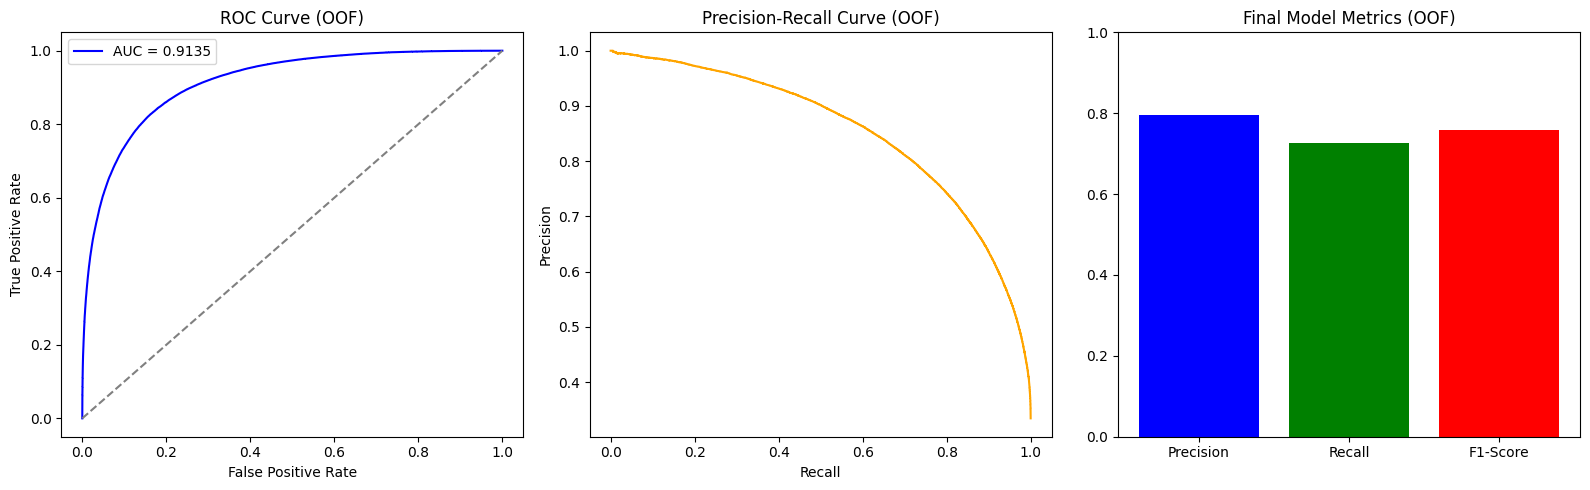

In [72]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, f1_score

# --- ROC and PR curves ---
fpr, tpr, _ = roc_curve(y, oof_preds)
precision_vals, recall_vals, _ = precision_recall_curve(y, oof_preds)

# --- Plotting ---
plt.figure(figsize=(16, 5))

# ROC Curve
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve (OOF)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()

# Precision-Recall Curve
plt.subplot(1, 3, 2)
plt.plot(recall_vals, precision_vals, color="orange")
plt.title("Precision-Recall Curve (OOF)")
plt.xlabel("Recall")
plt.ylabel("Precision")

# Bar Plot of Metrics
plt.subplot(1, 3, 3)
metrics = [precision, recall, f1]
labels = ['Precision', 'Recall', 'F1-Score']
colors = ['blue', 'green', 'red']
plt.bar(labels, metrics, color=colors)
plt.ylim(0, 1)
plt.title("Final Model Metrics (OOF)")

plt.tight_layout()
plt.show()


--- Current Model Performance --------

`AUC Score`: 0.9135

`Precision`: 0.7960

`Recall`:    0.7256

`F1-Score`:  0.7591


In [73]:
# Clean up memory
del X, y, X_train, X_val, y_train, y_val, train_full, models
gc.collect()


# Create the final submission DataFrame using the test_df created in the loop
submission_df = test_df[['customer_id', 'location_number', 'vendor_id']].copy()

# Use the averaged predictions from all 5 models (test_preds)
submission_df['target'] = test_preds

# Format the ID column as required: 'CID X LOC_NUM X VENDOR'
submission_df['CID X LOC_NUM X VENDOR'] = submission_df['customer_id'].astype(str) + ' X ' + submission_df['location_number'].astype(str) + ' X ' + submission_df['vendor_id'].astype(str)

# Select the final columns and save to CSV
final_submission = submission_df[['CID X LOC_NUM X VENDOR', 'target']]
final_submission.to_csv('submission_advanced.csv', index=False)

print("\nScript finished successfully!")
print("The submission file 'submission_advanced.csv' has been generated.")


Step 9/9: Generating submission file...

Script finished successfully!
The submission file 'submission_advanced.csv' has been generated.
